# Airlanes Delay
## Alberto Mastromarino mat.00302 AA 2022-2023

## Create Spark Session

### Import libraries

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as funct
import seaborn as sns
import matplotlib.pyplot as plt
import random
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, RobustScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BinaryEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MultiClassEvaluator

In [2]:
spark = SparkSession.builder.appName("Airlanes Delay").getOrCreate()

In [3]:
sc = spark.sparkContext

In [4]:
sc

<SparkContext master=local[*] appName=Airlanes Delay>

## Read the csv dataset

In [5]:
import os

In [6]:
ds_name = "airlines_delay.csv"
ds_path = "/Users/Alberto/Desktop"

In [7]:
df = spark.read.csv(os.path.join(ds_path,ds_name), inferSchema = True, header = True)

## Overview dataset

In [8]:
df.schema.fields

[StructField('Flight', DoubleType(), True),
 StructField('Time', DoubleType(), True),
 StructField('Length', DoubleType(), True),
 StructField('Airline', StringType(), True),
 StructField('AirportFrom', StringType(), True),
 StructField('AirportTo', StringType(), True),
 StructField('DayOfWeek', IntegerType(), True),
 StructField('Class', IntegerType(), True)]

In [9]:
df.columns

['Flight',
 'Time',
 'Length',
 'Airline',
 'AirportFrom',
 'AirportTo',
 'DayOfWeek',
 'Class']

In [10]:
df.count()

539382

In [11]:
len(df.columns)

8

In [12]:
df.show()

+------+------+------+-------+-----------+---------+---------+-----+
|Flight|  Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+------+------+-------+-----------+---------+---------+-----+
|2313.0|1296.0| 141.0|     DL|        ATL|      HOU|        1|    0|
|6948.0| 360.0| 146.0|     OO|        COS|      ORD|        4|    0|
|1247.0|1170.0| 143.0|     B6|        BOS|      CLT|        3|    0|
|  31.0|1410.0| 344.0|     US|        OGG|      PHX|        6|    0|
| 563.0| 692.0|  98.0|     FL|        BMI|      ATL|        4|    0|
|3692.0| 580.0|  60.0|     WN|        MSY|      BHM|        4|    0|
|1135.0| 690.0| 239.0|     CO|        EWR|      DFW|        4|    0|
|1300.0|1210.0|  80.0|     AA|        DFW|      MEM|        3|    0|
| 587.0|1295.0| 105.0|     FL|        BWI|      GRR|        7|    0|
| 764.0| 530.0| 108.0|     FL|        ATL|      PBI|        3|    0|
|1147.0|1103.0| 121.0|     FL|        CRW|      MCO|        4|    0|
|1440.0| 951.0|  79.0|     B6|    

In [13]:
df.head(5)

[Row(Flight=2313.0, Time=1296.0, Length=141.0, Airline='DL', AirportFrom='ATL', AirportTo='HOU', DayOfWeek=1, Class=0),
 Row(Flight=6948.0, Time=360.0, Length=146.0, Airline='OO', AirportFrom='COS', AirportTo='ORD', DayOfWeek=4, Class=0),
 Row(Flight=1247.0, Time=1170.0, Length=143.0, Airline='B6', AirportFrom='BOS', AirportTo='CLT', DayOfWeek=3, Class=0),
 Row(Flight=31.0, Time=1410.0, Length=344.0, Airline='US', AirportFrom='OGG', AirportTo='PHX', DayOfWeek=6, Class=0),
 Row(Flight=563.0, Time=692.0, Length=98.0, Airline='FL', AirportFrom='BMI', AirportTo='ATL', DayOfWeek=4, Class=0)]

In [14]:
df.tail(5)

[Row(Flight=6973.0, Time=530.0, Length=72.0, Airline='OO', AirportFrom='GEG', AirportTo='SEA', DayOfWeek=5, Class=1),
 Row(Flight=1264.0, Time=560.0, Length=115.0, Airline='WN', AirportFrom='LAS', AirportTo='DEN', DayOfWeek=4, Class=1),
 Row(Flight=5209.0, Time=827.0, Length=74.0, Airline='EV', AirportFrom='CAE', AirportTo='ATL', DayOfWeek=2, Class=1),
 Row(Flight=607.0, Time=715.0, Length=65.0, Airline='WN', AirportFrom='BWI', AirportTo='BUF', DayOfWeek=4, Class=1),
 Row(Flight=6377.0, Time=770.0, Length=55.0, Airline='OO', AirportFrom='CPR', AirportTo='DEN', DayOfWeek=2, Class=1)]

In [15]:
df.describe().show()

+-------+------------------+-----------------+------------------+-------+-----------+---------+------------------+-------------------+
|summary|            Flight|             Time|            Length|Airline|AirportFrom|AirportTo|         DayOfWeek|              Class|
+-------+------------------+-----------------+------------------+-------+-----------+---------+------------------+-------------------+
|  count|            539382|           539382|            539382| 539382|     539382|   539382|            539382|             539382|
|   mean|2427.9279879565875|802.7281611177236|132.20210351847115|   null|       null|     null| 3.929665802714959|0.44544311823531374|
| stddev|2067.4316995118197|278.0455455864742| 70.11704456829193|   null|       null|     null|1.9146655984563838|0.49701509497006235|
|    min|               1.0|             10.0|               0.0|     9E|        ABE|      ABE|                 1|                  0|
|    max|            7814.0|           1439.0|         

- Checking the class values 

In [16]:
df.groupBy("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|240264|
|    0|299118|
+-----+------+



In [17]:
df.groupBy("Flight").count().show()

+------+-----+
|Flight|count|
+------+-----+
|7115.0|   46|
| 596.0|  231|
| 305.0|  150|
|6454.0|   58|
| 299.0|  107|
|2734.0|  136|
| 769.0|  105|
|2862.0|  122|
|4142.0|   31|
|1051.0|  175|
|6433.0|   62|
| 496.0|  234|
|3980.0|   88|
| 934.0|  181|
| 558.0|  262|
|6653.0|   70|
| 692.0|  162|
|4800.0|   55|
|1761.0|  130|
|3901.0|   45|
+------+-----+
only showing top 20 rows



In [18]:
unique = [countDistinct(c).alias(c) for c in df.columns]
df.select(*unique).show()

+------+----+------+-------+-----------+---------+---------+-----+
|Flight|Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+----+------+-------+-----------+---------+---------+-----+
|  6585|1131|   426|     18|        293|      293|        7|    2|
+------+----+------+-------+-----------+---------+---------+-----+



# Data Cleaning

### Remove Na, duplicate rows, useless columns, wrong values


- Checking if there are missing values

In [19]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+------+-------+-----------+---------+---------+-----+
|Flight|Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+----+------+-------+-----------+---------+---------+-----+
|     0|   0|     0|      0|          0|        0|        0|    0|
+------+----+------+-------+-----------+---------+---------+-----+



- Remove the flight ID column

In [20]:
df = df.drop("Flight")

In [21]:
len(df.columns)

7

In [22]:
df.count()

539382

In [23]:
df.show()

+------+------+-------+-----------+---------+---------+-----+
|  Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+------+-------+-----------+---------+---------+-----+
|1296.0| 141.0|     DL|        ATL|      HOU|        1|    0|
| 360.0| 146.0|     OO|        COS|      ORD|        4|    0|
|1170.0| 143.0|     B6|        BOS|      CLT|        3|    0|
|1410.0| 344.0|     US|        OGG|      PHX|        6|    0|
| 692.0|  98.0|     FL|        BMI|      ATL|        4|    0|
| 580.0|  60.0|     WN|        MSY|      BHM|        4|    0|
| 690.0| 239.0|     CO|        EWR|      DFW|        4|    0|
|1210.0|  80.0|     AA|        DFW|      MEM|        3|    0|
|1295.0| 105.0|     FL|        BWI|      GRR|        7|    0|
| 530.0| 108.0|     FL|        ATL|      PBI|        3|    0|
|1103.0| 121.0|     FL|        CRW|      MCO|        4|    0|
| 951.0|  79.0|     B6|        LGB|      SFO|        7|    0|
|1215.0| 102.0|     OO|        BIS|      DEN|        4|    0|
|1189.0|

## Data visualization

-- I converted the minute count into parts of the day
- 0-4 late night 240 minutes
- 4-8 early morning 480 minutes
- 8-12 morning 720 minutes
- 12-16 afternoon 960 minutes
- 16-20 evening 1200 minutes
- 20-24 night 1440 minutes

-- I also converted numbers from 1 to 7 into days of the week

In [24]:
df_minute = df.toPandas()

In [25]:
df_minute

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,DL,ATL,HOU,1,0
1,360.0,146.0,OO,COS,ORD,4,0
2,1170.0,143.0,B6,BOS,CLT,3,0
3,1410.0,344.0,US,OGG,PHX,6,0
4,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...
539377,530.0,72.0,OO,GEG,SEA,5,1
539378,560.0,115.0,WN,LAS,DEN,4,1
539379,827.0,74.0,EV,CAE,ATL,2,1
539380,715.0,65.0,WN,BWI,BUF,4,1


In [26]:
def daytime(lista):
    interval_dict = {
        (0, 240): "Late night",
        (240, 480): "Early morning",
        (480, 720): "Morning",
        (720, 960): "Afternoon",
        (960, 1220): "Evening",
        (1220, 1440): "Night"
    }
    
    lista_n = [interval_dict[k] for i in lista for k in interval_dict.keys() if k[0] < i <= k[1]]
    
    return lista_n

df_minute["Time"] = daytime(df_minute["Time"])

In [27]:
df_minute.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,Night,141.0,DL,ATL,HOU,1,0
1,Early morning,146.0,OO,COS,ORD,4,0
2,Evening,143.0,B6,BOS,CLT,3,0
3,Night,344.0,US,OGG,PHX,6,0
4,Morning,98.0,FL,BMI,ATL,4,0


In [28]:
def replace_day_of_week(df):
    day_mapping = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}

    df["DayOfWeek"] = df["DayOfWeek"].map(day_mapping)

    return df

df_minute = replace_day_of_week(df_minute)

In [29]:
df_minute.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,Night,141.0,DL,ATL,HOU,Monday,0
1,Early morning,146.0,OO,COS,ORD,Thursday,0
2,Evening,143.0,B6,BOS,CLT,Wednesday,0
3,Night,344.0,US,OGG,PHX,Saturday,0
4,Morning,98.0,FL,BMI,ATL,Thursday,0


In [30]:
days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
time_order = ["Late night", "Early morning", "Morning", "Afternoon", "Evening", "Night"]

In [31]:
df_minute.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,Night,141.0,DL,ATL,HOU,Monday,0
1,Early morning,146.0,OO,COS,ORD,Thursday,0
2,Evening,143.0,B6,BOS,CLT,Wednesday,0
3,Night,344.0,US,OGG,PHX,Saturday,0
4,Morning,98.0,FL,BMI,ATL,Thursday,0


<Axes: xlabel='Airline', ylabel='count'>

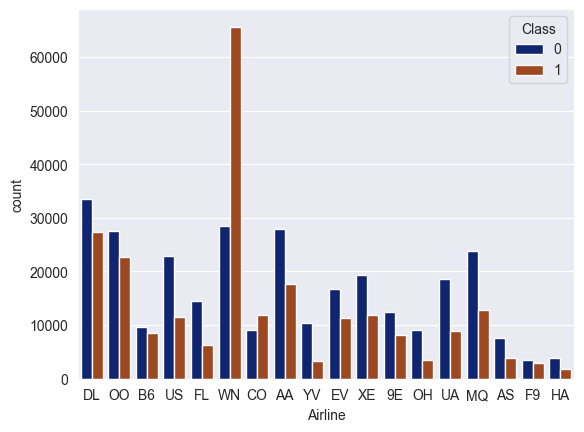

In [32]:
sns.countplot(x='Airline', hue='Class', data=df_minute, palette = "dark")

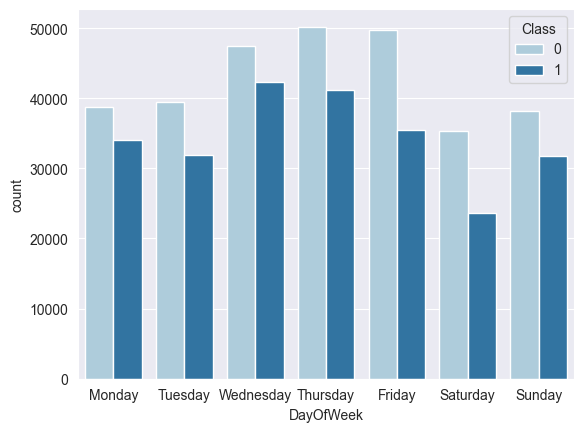

In [33]:
sns.countplot(x='DayOfWeek', hue='Class', data=df_minute, palette = "Paired", order = days_order)

sns.set(rc = {'figure.figsize':(14,8)})

    DayOfWeek  Class   Percent
0      Friday      0  0.583387
1      Friday      1  0.416613
2      Monday      0  0.532356
3      Monday      1  0.467644
4    Saturday      0  0.599447
5    Saturday      1  0.400553
6      Sunday      0  0.546459
7      Sunday      1  0.453541
8    Thursday      0  0.548975
9    Thursday      1  0.451025
10    Tuesday      0  0.552663
11    Tuesday      1  0.447337
12  Wednesday      0  0.529182
13  Wednesday      1  0.470818


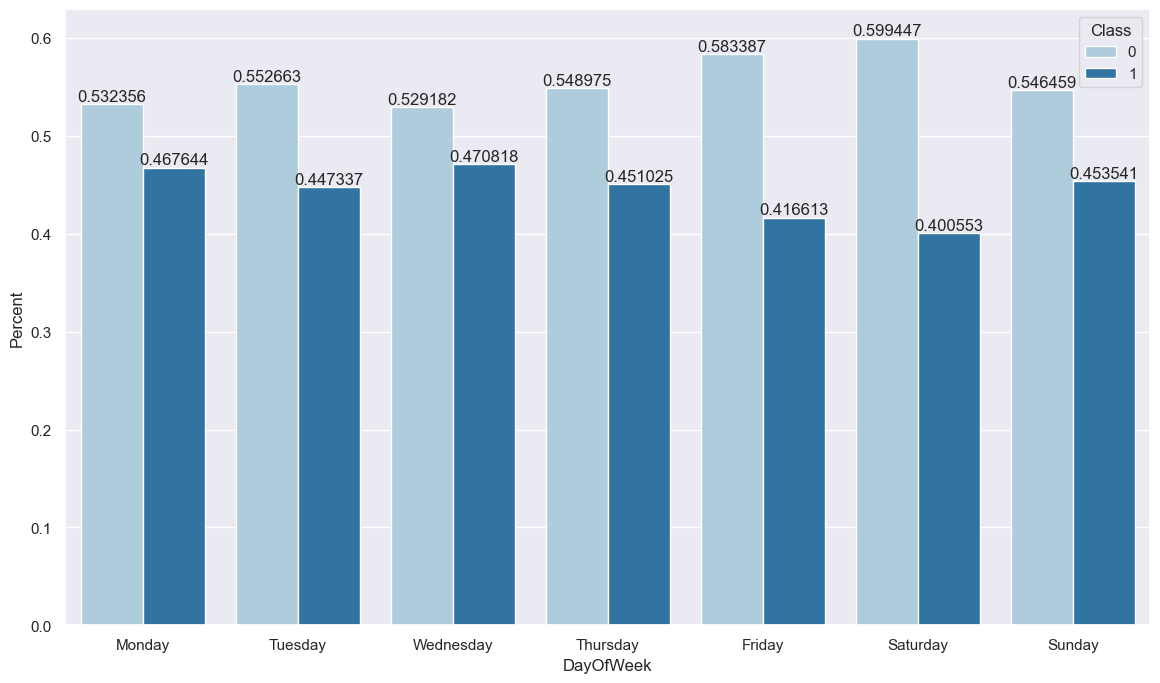

In [34]:
df_cxa = df_minute.groupby("DayOfWeek")["Class"].value_counts(normalize=True)
df_cxa = df_cxa.mul(1).rename('Percent').reset_index()
print(df_cxa)

df_cxa_p =sns.barplot(data=df_cxa,x="DayOfWeek",y="Percent",hue="Class", palette = "Paired", order = days_order)
for i in df_cxa_p.containers:
    df_cxa_p.bar_label(i,)

sns.set(rc = {'figure.figsize':(20,8)})

   Airline  Class   Percent
0       9E      0  0.602340
1       9E      1  0.397660
2       AA      0  0.611530
3       AA      1  0.388470
4       AS      0  0.660710
5       AS      1  0.339290
6       B6      0  0.532962
7       B6      1  0.467038
8       CO      1  0.566199
9       CO      0  0.433801
10      DL      0  0.549524
11      DL      1  0.450476
12      EV      0  0.597792
13      EV      1  0.402208
14      F9      0  0.550960
15      F9      1  0.449040
16      FL      0  0.698708
17      FL      1  0.301292
18      HA      0  0.679814
19      HA      1  0.320186
20      MQ      0  0.651896
21      MQ      1  0.348104
22      OH      0  0.722724
23      OH      1  0.277276
24      OO      0  0.547101
25      OO      1  0.452899
26      UA      0  0.676093
27      UA      1  0.323907
28      US      0  0.664029
29      US      1  0.335971
30      WN      1  0.697759
31      WN      0  0.302241
32      XE      0  0.621056
33      XE      1  0.378944
34      YV      0  0

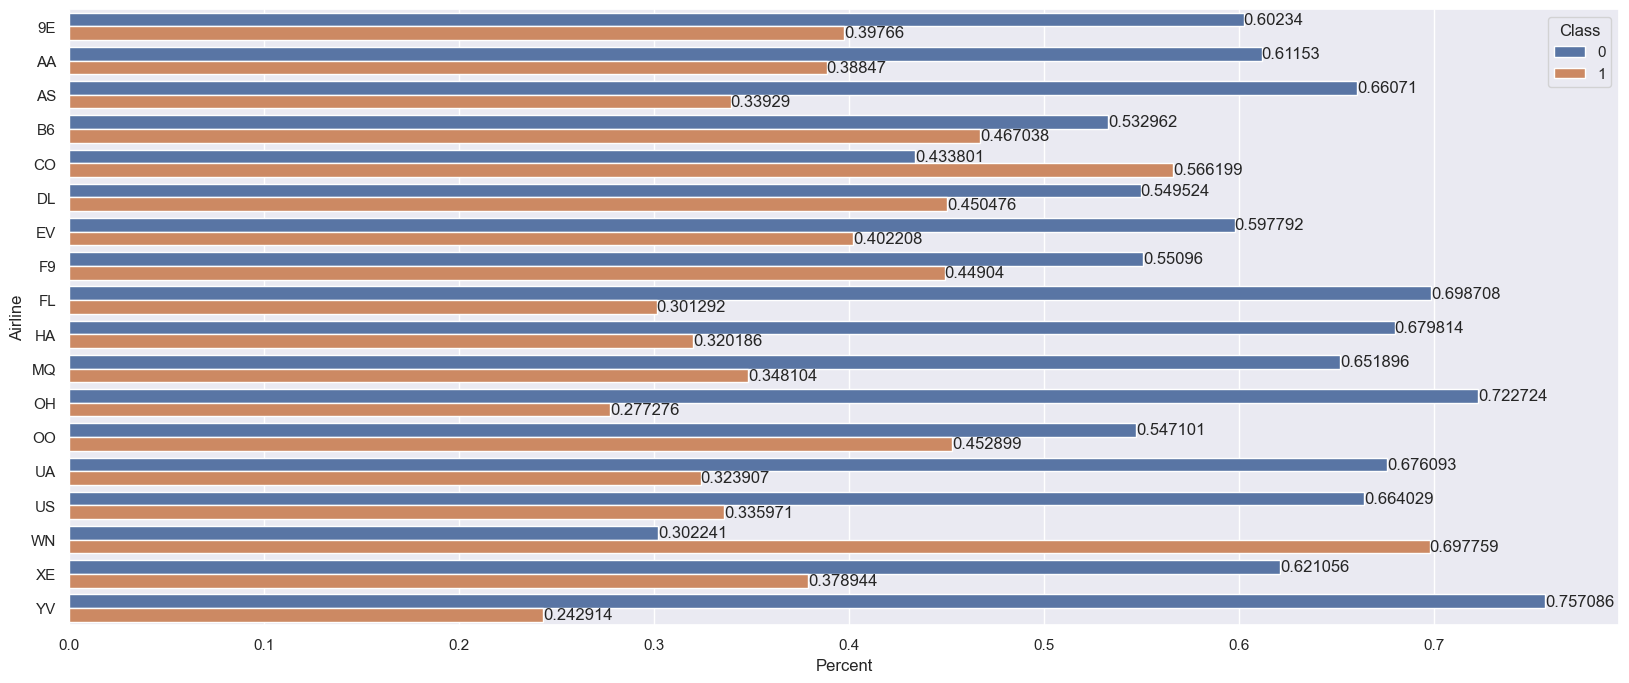

In [35]:
df_cxa = df_minute.groupby("Airline")["Class"].value_counts(normalize=True)
df_cxa = df_cxa.mul(1).rename('Percent').reset_index()
print(df_cxa)

df_cxa_p =sns.barplot(data=df_cxa,x="Percent",y="Airline",hue="Class")
for i in df_cxa_p.containers:
    df_cxa_p.bar_label(i,)

sns.set(rc = {'figure.figsize':(20,14)})

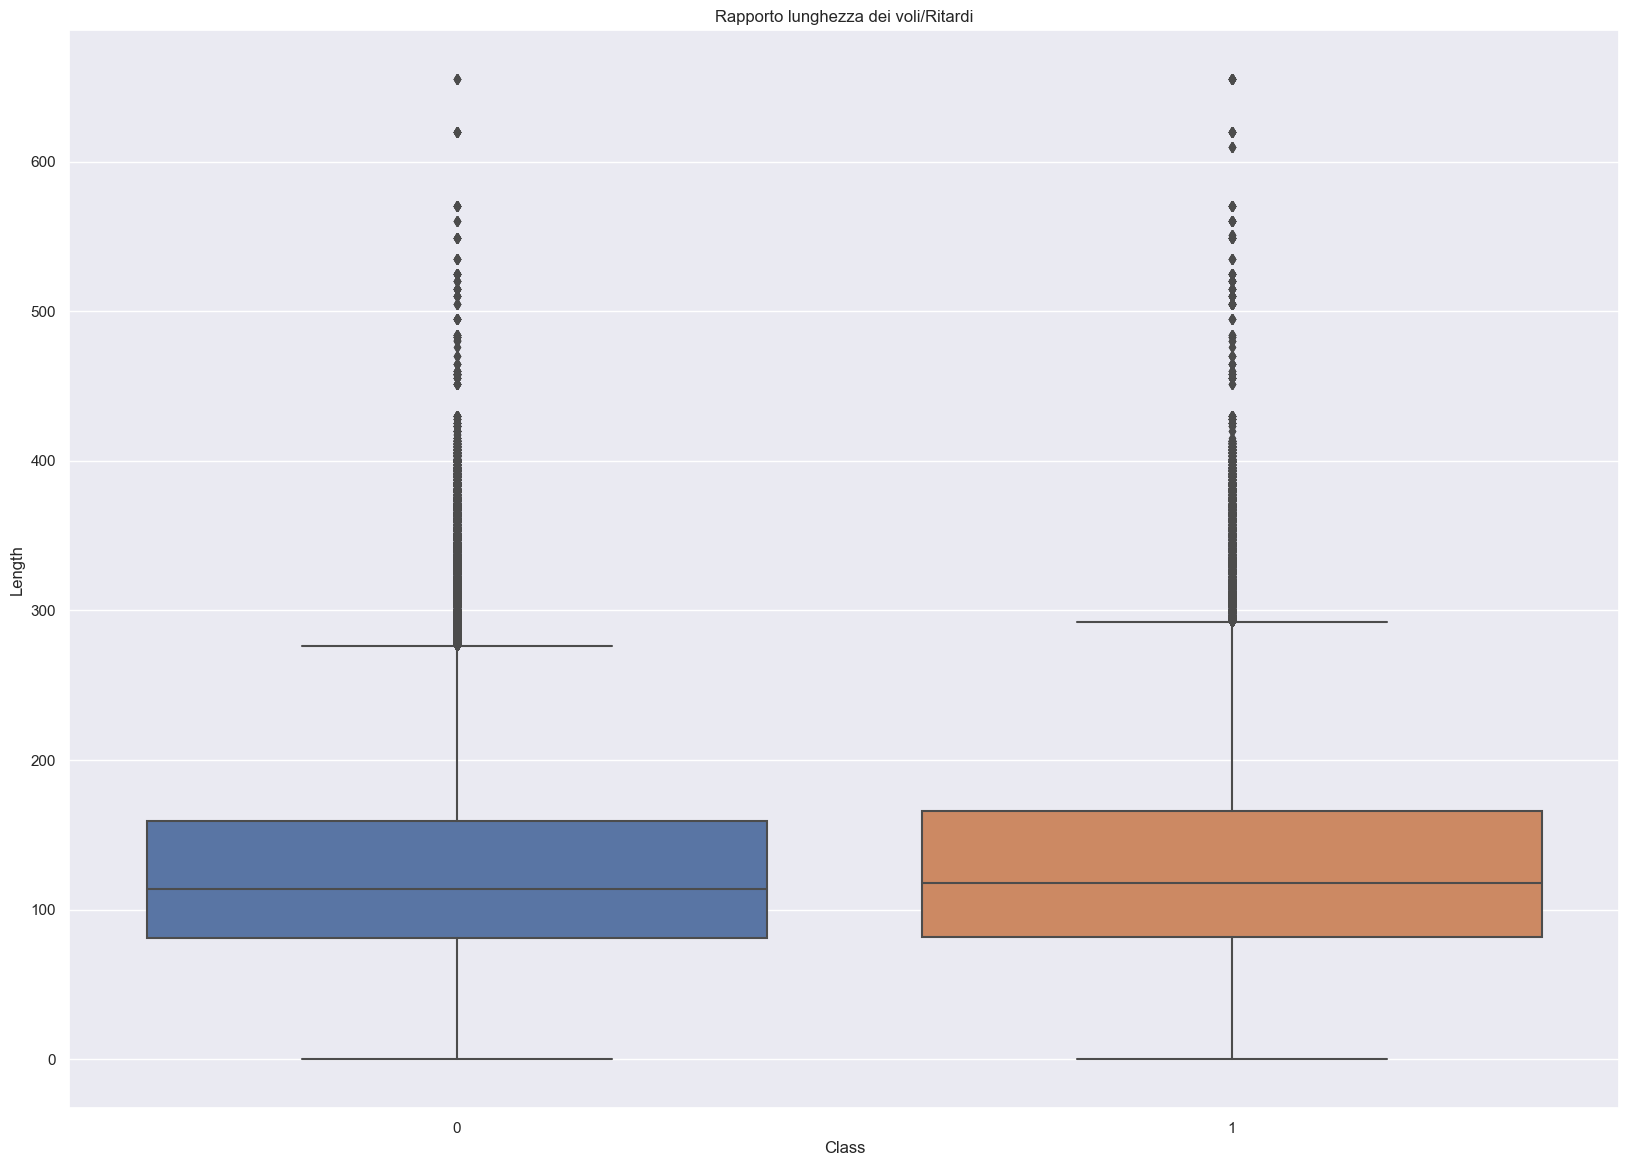

In [36]:
sns.boxplot(x="Class", y="Length", data=df_minute).set(title="Rapporto lunghezza dei voli/Ritardi")

sns.set(rc = {'figure.figsize':(20,8)})

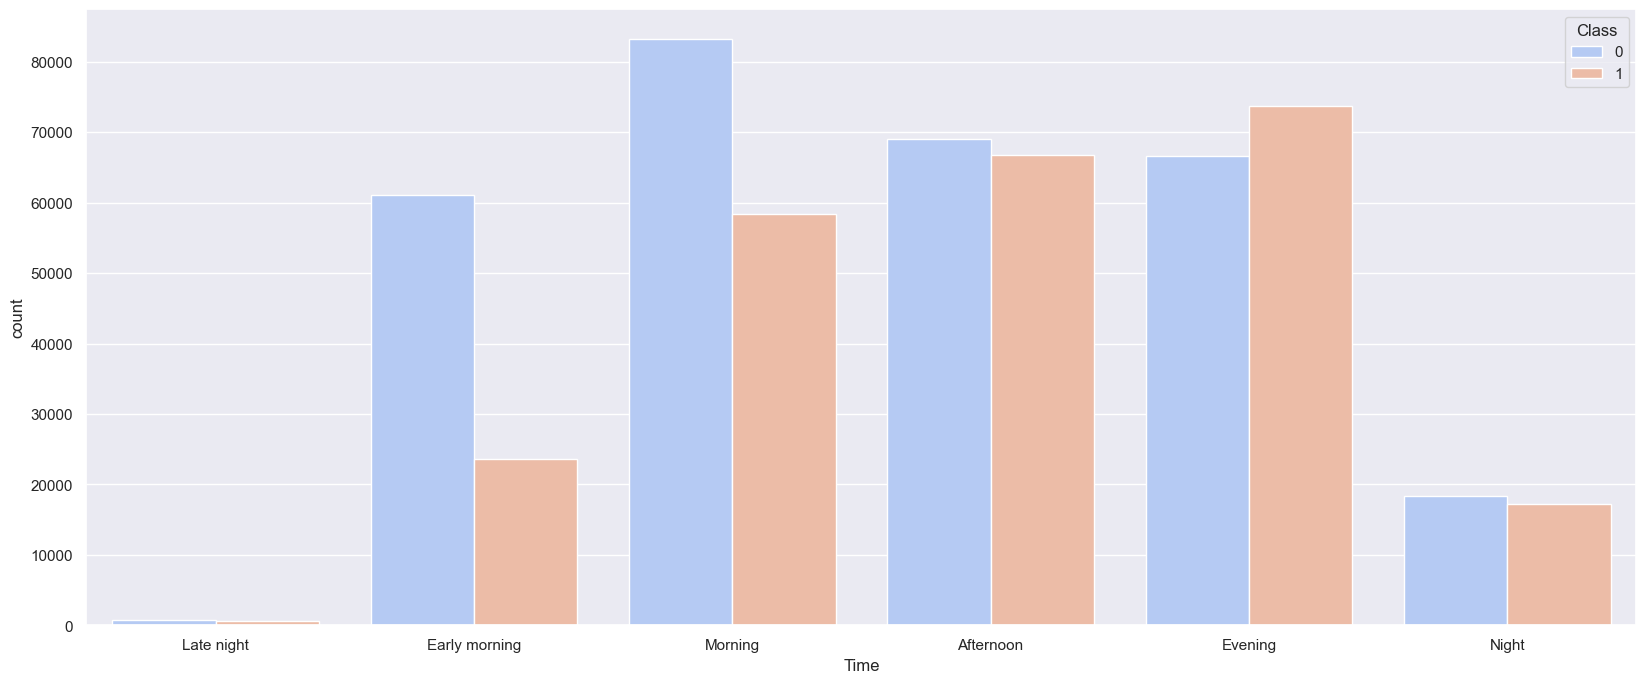

In [37]:
sns.countplot(x='Time', hue='Class', data=df_minute, palette = "coolwarm", order = time_order)

sns.set(rc = {'figure.figsize':(14,8)})

             Time  Class   Percent
0       Afternoon      0  0.508314
1       Afternoon      1  0.491686
2   Early morning      0  0.721714
3   Early morning      1  0.278286
4         Evening      1  0.525215
5         Evening      0  0.474785
6      Late night      0  0.552839
7      Late night      1  0.447161
8         Morning      0  0.587635
9         Morning      1  0.412365
10          Night      0  0.516117
11          Night      1  0.483883


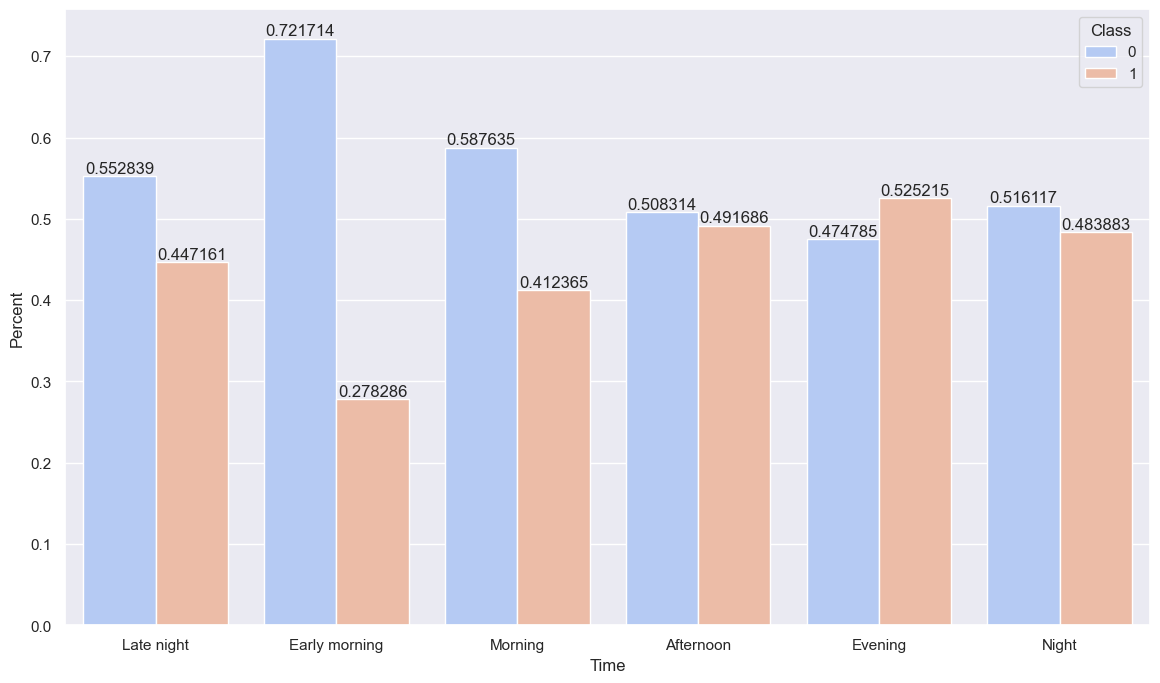

In [38]:
df_cxa = df_minute.groupby("Time")["Class"].value_counts(normalize=True)
df_cxa = df_cxa.mul(1).rename('Percent').reset_index()
print(df_cxa)

df_cxa_p =sns.barplot(data=df_cxa,x="Time",y="Percent",hue="Class", palette = "coolwarm", order = time_order)
for i in df_cxa_p.containers:
    df_cxa_p.bar_label(i,)

sns.set(rc = {'figure.figsize':(20,8)})

## Matrice di correlazione

In [39]:
df_cm = df.toPandas()

In [40]:
df_cm

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,DL,ATL,HOU,1,0
1,360.0,146.0,OO,COS,ORD,4,0
2,1170.0,143.0,B6,BOS,CLT,3,0
3,1410.0,344.0,US,OGG,PHX,6,0
4,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...
539377,530.0,72.0,OO,GEG,SEA,5,1
539378,560.0,115.0,WN,LAS,DEN,4,1
539379,827.0,74.0,EV,CAE,ATL,2,1
539380,715.0,65.0,WN,BWI,BUF,4,1


In [41]:
corr = df_cm.corr()
corr

C:\Users\Frong\AppData\Local\Temp\ipykernel_15052\470216087.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_cm.corr()


,Time,Length,DayOfWeek,Class
Time,1.000000,-0.020610,0.001272,0.150457
Length,-0.020610,1.000000,0.013398,0.040488
DayOfWeek,0.001272,0.013398,1.000000,-0.026198
Class,0.150457,0.040488,-0.026198,1.000000


In [42]:
corr.style.background_gradient(cmap = 'coolwarm')

,Time,Length,DayOfWeek,Class
Time,1.000000,-0.020610,0.001272,0.150457
Length,-0.020610,1.000000,0.013398,0.040488
DayOfWeek,0.001272,0.013398,1.000000,-0.026198
Class,0.150457,0.040488,-0.026198,1.000000


## Casting and encoding

- Convert variables type

In [43]:
df = df.withColumn("Length",funct.round(df["Length"]).cast("Integer"))

In [44]:
df.printSchema()
df.show()

root
 |-- Time: double (nullable = true)
 |-- Length: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Class: integer (nullable = true)

+------+------+-------+-----------+---------+---------+-----+
|  Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|
+------+------+-------+-----------+---------+---------+-----+
|1296.0|   141|     DL|        ATL|      HOU|        1|    0|
| 360.0|   146|     OO|        COS|      ORD|        4|    0|
|1170.0|   143|     B6|        BOS|      CLT|        3|    0|
|1410.0|   344|     US|        OGG|      PHX|        6|    0|
| 692.0|    98|     FL|        BMI|      ATL|        4|    0|
| 580.0|    60|     WN|        MSY|      BHM|        4|    0|
| 690.0|   239|     CO|        EWR|      DFW|        4|    0|
|1210.0|    80|     AA|        DFW|      MEM|        3|    0|
|1295.0|   105|     FL|        BWI

## Data Pre-Processing

## Quantitative Variables

In [45]:
Length_vec= [VectorAssembler(inputCols=["Length"], outputCol="Length_vec")]
robust_scaler1 = [RobustScaler(inputCol="Length_vec", outputCol="Length_robust")]

assblr_2= [VectorAssembler(inputCols=["Time","DayOfWeek"], outputCol="Time_Day_vec")]
MinMaxScaler2 = [MinMaxScaler(inputCol="Time_Day_vec", outputCol="Time_Day_minmax")]

pipeline = Pipeline(stages=Length_vec+robust_scaler1+assblr_2+MinMaxScaler2)

pipe = pipeline.fit(df)
scaled_df = pipe.transform(df)
scaled_df.show()

+------+------+-------+-----------+---------+---------+-----+----------+--------------------+------------+--------------------+
|  Time|Length|Airline|AirportFrom|AirportTo|DayOfWeek|Class|Length_vec|       Length_robust|Time_Day_vec|     Time_Day_minmax|
+------+------+-------+-----------+---------+---------+-----+----------+--------------------+------------+--------------------+
|1296.0|   141|     DL|        ATL|      HOU|        1|    0|   [141.0]|[1.7407407407407407]|[1296.0,1.0]|[0.89993002099370...|
| 360.0|   146|     OO|        COS|      ORD|        4|    0|   [146.0]|[1.8024691358024691]| [360.0,4.0]|[0.24492652204338...|
|1170.0|   143|     B6|        BOS|      CLT|        3|    0|   [143.0]| [1.765432098765432]|[1170.0,3.0]|[0.81175647305808...|
|1410.0|   344|     US|        OGG|      PHX|        6|    0|   [344.0]| [4.246913580246913]|[1410.0,6.0]|[0.97970608817354...|
| 692.0|    98|     FL|        BMI|      ATL|        4|    0|    [98.0]|[1.2098765432098766]| [692.0,4.0

In [46]:
scaled_df= scaled_df.drop("Length")
scaled_df=scaled_df.drop("Length_vec")
scaled_df=scaled_df.drop("Time")
scaled_df=scaled_df.drop("DayOfWeek")
scaled_df=scaled_df.drop("Time_Day_vec")

scaled_df.show()

+-------+-----------+---------+-----+--------------------+--------------------+
|Airline|AirportFrom|AirportTo|Class|       Length_robust|     Time_Day_minmax|
+-------+-----------+---------+-----+--------------------+--------------------+
|     DL|        ATL|      HOU|    0|[1.7407407407407407]|[0.89993002099370...|
|     OO|        COS|      ORD|    0|[1.8024691358024691]|[0.24492652204338...|
|     B6|        BOS|      CLT|    0| [1.765432098765432]|[0.81175647305808...|
|     US|        OGG|      PHX|    0| [4.246913580246913]|[0.97970608817354...|
|     FL|        BMI|      ATL|    0|[1.2098765432098766]|[0.47725682295311...|
|     WN|        MSY|      BHM|    0|[0.7407407407407407]|[0.39888033589923...|
|     CO|        EWR|      DFW|    0| [2.950617283950617]|[0.47585724282715...|
|     AA|        DFW|      MEM|    0|[0.9876543209876543]|[0.83974807557732...|
|     FL|        BWI|      GRR|    0|[1.2962962962962963]|[0.89923023093072...|
|     FL|        ATL|      PBI|    0|[1.

### Qualitative Variables

In [47]:
scaled_df.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- Class: integer (nullable = true)
 |-- Length_robust: vector (nullable = true)
 |-- Time_Day_minmax: vector (nullable = true)



In [48]:
indexer = StringIndexer(inputCols =("Airline","AirportFrom","AirportTo"),outputCols = ("AirlineIND","AirportFromIND","AirportToIND"))

In [49]:
indexed = indexer.fit(scaled_df).transform(scaled_df)
indexed.show()

+-------+-----------+---------+-----+--------------------+--------------------+----------+--------------+------------+
|Airline|AirportFrom|AirportTo|Class|       Length_robust|     Time_Day_minmax|AirlineIND|AirportFromIND|AirportToIND|
+-------+-----------+---------+-----+--------------------+--------------------+----------+--------------+------------+
|     DL|        ATL|      HOU|    0|[1.7407407407407407]|[0.89993002099370...|       1.0|           0.0|        33.0|
|     OO|        COS|      ORD|    0|[1.8024691358024691]|[0.24492652204338...|       2.0|          82.0|         1.0|
|     B6|        BOS|      CLT|    0| [1.765432098765432]|[0.81175647305808...|      12.0|          16.0|        10.0|
|     US|        OGG|      PHX|    0| [4.246913580246913]|[0.97970608817354...|       5.0|          63.0|         6.0|
|     FL|        BMI|      ATL|    0|[1.2098765432098766]|[0.47725682295311...|      10.0|         139.0|         0.0|
|     WN|        MSY|      BHM|    0|[0.74074074

In [50]:
encoder = OneHotEncoder(inputCols= ("AirlineIND","AirportFromIND","AirportToIND"),outputCols=('AirlineENC','AirportFromENC',"AirportToENC"))

In [51]:
encoded_df = encoder.fit(indexed).transform(indexed)

In [52]:
encoded_df.show()

+-------+-----------+---------+-----+--------------------+--------------------+----------+--------------+------------+---------------+-----------------+-----------------+
|Airline|AirportFrom|AirportTo|Class|       Length_robust|     Time_Day_minmax|AirlineIND|AirportFromIND|AirportToIND|     AirlineENC|   AirportFromENC|     AirportToENC|
+-------+-----------+---------+-----+--------------------+--------------------+----------+--------------+------------+---------------+-----------------+-----------------+
|     DL|        ATL|      HOU|    0|[1.7407407407407407]|[0.89993002099370...|       1.0|           0.0|        33.0| (17,[1],[1.0])|  (292,[0],[1.0])| (292,[33],[1.0])|
|     OO|        COS|      ORD|    0|[1.8024691358024691]|[0.24492652204338...|       2.0|          82.0|         1.0| (17,[2],[1.0])| (292,[82],[1.0])|  (292,[1],[1.0])|
|     B6|        BOS|      CLT|    0| [1.765432098765432]|[0.81175647305808...|      12.0|          16.0|        10.0|(17,[12],[1.0])| (292,[16],

In [53]:
encoded_df.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- AirportFrom: string (nullable = true)
 |-- AirportTo: string (nullable = true)
 |-- Class: integer (nullable = true)
 |-- Length_robust: vector (nullable = true)
 |-- Time_Day_minmax: vector (nullable = true)
 |-- AirlineIND: double (nullable = false)
 |-- AirportFromIND: double (nullable = false)
 |-- AirportToIND: double (nullable = false)
 |-- AirlineENC: vector (nullable = true)
 |-- AirportFromENC: vector (nullable = true)
 |-- AirportToENC: vector (nullable = true)



In [54]:
encoded_clean_df = encoded_df.drop("Airline","AirportFrom","AirportTo","AirlineIND","AirportFromIND","AirportToIND")
encoded_clean_df.printSchema()
encoded_clean_df.show()

root
 |-- Class: integer (nullable = true)
 |-- Length_robust: vector (nullable = true)
 |-- Time_Day_minmax: vector (nullable = true)
 |-- AirlineENC: vector (nullable = true)
 |-- AirportFromENC: vector (nullable = true)
 |-- AirportToENC: vector (nullable = true)

+-----+--------------------+--------------------+---------------+-----------------+-----------------+
|Class|       Length_robust|     Time_Day_minmax|     AirlineENC|   AirportFromENC|     AirportToENC|
+-----+--------------------+--------------------+---------------+-----------------+-----------------+
|    0|[1.7407407407407407]|[0.89993002099370...| (17,[1],[1.0])|  (292,[0],[1.0])| (292,[33],[1.0])|
|    0|[1.8024691358024691]|[0.24492652204338...| (17,[2],[1.0])| (292,[82],[1.0])|  (292,[1],[1.0])|
|    0| [1.765432098765432]|[0.81175647305808...|(17,[12],[1.0])| (292,[16],[1.0])| (292,[10],[1.0])|
|    0| [4.246913580246913]|[0.97970608817354...| (17,[5],[1.0])| (292,[63],[1.0])|  (292,[6],[1.0])|
|    0|[1.20987654

## Vector Assembler operation to create feature's vector (X)

In [55]:
final_assembler = VectorAssembler(inputCols=["Length_robust", "Time_Day_minmax", "AirlineENC","AirportFromENC","AirportToENC"], outputCol='Features')

In [56]:
transform = final_assembler.transform(encoded_clean_df)
transform.show()

+-----+--------------------+--------------------+---------------+-----------------+-----------------+--------------------+
|Class|       Length_robust|     Time_Day_minmax|     AirlineENC|   AirportFromENC|     AirportToENC|            Features|
+-----+--------------------+--------------------+---------------+-----------------+-----------------+--------------------+
|    0|[1.7407407407407407]|[0.89993002099370...| (17,[1],[1.0])|  (292,[0],[1.0])| (292,[33],[1.0])|(604,[0,1,4,20,34...|
|    0|[1.8024691358024691]|[0.24492652204338...| (17,[2],[1.0])| (292,[82],[1.0])|  (292,[1],[1.0])|(604,[0,1,2,5,102...|
|    0| [1.765432098765432]|[0.81175647305808...|(17,[12],[1.0])| (292,[16],[1.0])| (292,[10],[1.0])|(604,[0,1,2,15,36...|
|    0| [4.246913580246913]|[0.97970608817354...| (17,[5],[1.0])| (292,[63],[1.0])|  (292,[6],[1.0])|(604,[0,1,2,8,83,...|
|    0|[1.2098765432098766]|[0.47725682295311...|(17,[10],[1.0])|(292,[139],[1.0])|  (292,[0],[1.0])|(604,[0,1,2,13,15...|
|    0|[0.740740

In [57]:
final_df = transform.select("Class","Features")

In [58]:
final_df.show()

+-----+--------------------+
|Class|            Features|
+-----+--------------------+
|    0|(604,[0,1,4,20,34...|
|    0|(604,[0,1,2,5,102...|
|    0|(604,[0,1,2,15,36...|
|    0|(604,[0,1,2,8,83,...|
|    0|(604,[0,1,2,13,15...|
|    0|(604,[0,1,2,3,64,...|
|    0|(604,[0,1,2,12,34...|
|    0|(604,[0,1,2,6,22,...|
|    0|(604,[0,1,2,13,37...|
|    0|(604,[0,1,2,13,20...|
|    0|(604,[0,1,2,13,16...|
|    0|(604,[0,1,2,15,98...|
|    0|(604,[0,1,2,5,173...|
|    0|(604,[0,1,2,16,30...|
|    0|(604,[0,1,2,8,25,...|
|    0|(604,[0,1,2,5,24,...|
|    0|(604,[0,1,2,13,70...|
|    0|(604,[0,1,2,10,20...|
|    0|(604,[0,1,2,9,121...|
|    0|(604,[0,1,14,50,3...|
+-----+--------------------+
only showing top 20 rows



## Division into training set and test set


In [59]:
random.seed(1)
training, test = final_df.randomSplit([0.8,0.2], seed=0)

In [60]:
(training.count(), test.count())

(431436, 107946)

# Machine Learning models

## Random forest

#### Parametri scelti arbitrariamente

In [61]:
from pyspark.ml.classification import RandomForestClassifier

In [63]:
classifier = RandomForestClassifier(maxDepth=14, numTrees=25, labelCol="Class", featuresCol="Features")
model = classifier.fit(training)

In [64]:
model.featureImportances

SparseVector(604, {0: 0.0278, 1: 0.1791, 2: 0.0117, 3: 0.3095, 4: 0.0043, 5: 0.0028, 6: 0.0067, 7: 0.0162, 8: 0.0361, 9: 0.0063, 10: 0.0011, 11: 0.0219, 12: 0.0259, 13: 0.0221, 14: 0.0012, 15: 0.0016, 16: 0.0314, 17: 0.0245, 18: 0.0057, 19: 0.0007, 20: 0.0018, 21: 0.0075, 22: 0.0009, 23: 0.0004, 24: 0.0024, 25: 0.0041, 26: 0.0015, 27: 0.0012, 28: 0.0078, 29: 0.0031, 30: 0.0016, 31: 0.0009, 32: 0.0025, 33: 0.001, 34: 0.0004, 35: 0.0009, 36: 0.0005, 37: 0.0077, 38: 0.0008, 39: 0.0007, 40: 0.0003, 41: 0.0308, 42: 0.0033, 43: 0.0002, 44: 0.0004, 45: 0.0065, 46: 0.0011, 47: 0.001, 48: 0.0005, 49: 0.0007, 50: 0.0004, 51: 0.0005, 52: 0.0014, 53: 0.0058, 54: 0.0003, 55: 0.0001, 56: 0.0004, 57: 0.0001, 58: 0.0005, 59: 0.0176, 60: 0.0184, 61: 0.0003, 62: 0.0003, 63: 0.0046, 64: 0.0004, 65: 0.0018, 66: 0.0002, 67: 0.0002, 68: 0.0003, 69: 0.0005, 70: 0.0003, 71: 0.0011, 72: 0.0001, 73: 0.0003, 74: 0.0001, 75: 0.0001, 76: 0.0001, 77: 0.0001, 78: 0.0001, 79: 0.0004, 80: 0.0001, 81: 0.0003, 82: 0.0, 

##Test the model and make performance evaluation

In [65]:
predictions = model.transform(test)

In [66]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|Class|            Features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(604,[0,1,2,3,23,...|[12.0829060967107...|[0.48331624386842...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.6943539736292...|[0.42777415894517...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.4865134326867...|[0.41946053730746...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.7516681136152...|[0.43006672454461...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.2914638353625...|[0.41165855341450...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.6193197148371...|[0.46477278859348...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.8357177497441...|[0.47342870998976...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.9105896849016...|[0.47642358739606...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.5495431176131...|[0.46198172470452...|       1.0|
|    0|(604,[0,1

In [67]:
evaluator = MultiClassEvaluator (predictionCol = 'prediction', labelCol = 'Class', metricName = 'accuracy')

In [68]:
accuracyRF = evaluator.evaluate(predictions)

In [69]:
print(f'Accuracy Random Forest è pari a {accuracyRF}')

Accuracy Random Forest è pari a 0.6340114501695292


## Naive Bayes

In [70]:
from pyspark.ml.classification import NaiveBayes

In [71]:
classifier2 = NaiveBayes(labelCol='Class', featuresCol="Features")
model2= classifier.fit(training)

In [72]:
predictions_2 = model2.transform(test)

In [73]:
predictions_2.show()

+-----+--------------------+--------------------+--------------------+----------+
|Class|            Features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(604,[0,1,2,3,23,...|[12.0829060967107...|[0.48331624386842...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.6943539736292...|[0.42777415894517...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.4865134326867...|[0.41946053730746...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.7516681136152...|[0.43006672454461...|       1.0|
|    0|(604,[0,1,2,3,23,...|[10.2914638353625...|[0.41165855341450...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.6193197148371...|[0.46477278859348...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.8357177497441...|[0.47342870998976...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.9105896849016...|[0.47642358739606...|       1.0|
|    0|(604,[0,1,2,3,23,...|[11.5495431176131...|[0.46198172470452...|       1.0|
|    0|(604,[0,1

In [74]:
tester = BinaryEvaluator(rawPredictionCol='prediction', labelCol='Class')

In [75]:
accuracyNB = tester.evaluate(predictions_2)

In [76]:
print("Valutazione delle prestazioni:")
print(f"Accuratezza: {accuracyNB:}")

Valutazione delle prestazioni:
Accuratezza: 0.6015735565174063


##Logistic

In [77]:
from pyspark.ml.classification import LogisticRegression as LogisticRegressor

In [78]:
regressor = LogisticRegressor(featuresCol="Features", labelCol='Class')

In [79]:
model = regressor.fit(training)

In [80]:
performance = model.evaluate(test)

In [81]:
predictions = performance.predictions.select('Class', 'prediction')

In [82]:
predictions.show(20)

+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 20 rows



In [83]:
evaluator = BinaryEvaluator(rawPredictionCol='prediction', labelCol='Class')

In [84]:
accuracyLOG = evaluator.evaluate(predictions)

In [85]:
print(f"Accuracy: {accuracyLOG}")

Accuracy: 0.6293179896151048


# Comparison of results

In [86]:
data_results= [{'Algorithm': 'Naive Bayes', 'Performance(accuracy)': accuracyNB},
        {'Algorithm': 'Random Forest', 'Performance(accuracy)': accuracyRF},
        {'Algorithm': 'Logistic Regression', 'Performance(accuracy)': accuracyLOG}]
  
df_results  = spark.createDataFrame(data_results)
  
df_results.show()

+-------------------+---------------------+
|          Algorithm|Performance(accuracy)|
+-------------------+---------------------+
|        Naive Bayes|   0.6015735565174063|
|      Random Forest|   0.6340114501695292|
|Logistic Regression|   0.6293179896151048|
+-------------------+---------------------+



# Close the Spark Session

In [87]:
spark.stop()